In [61]:
import os
import sys
import rpy2.robjects.lib.ggplot2 as ggplot2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
%load_ext autoreload
%load_ext autotime

sys.path.append('../../')
from src.analysis import child_analysis
from src.analysis import load_splits

%load_ext rpy2.ipython
%R library(plotROC)
%R library('pROC')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['pROC', 'plotROC', 'ggplot2', 'lazyeval', 'rlang', 'tools',
       'stats', 'graphics', 'grDevices', 'utils', 'datasets', 'methods',
       'base'], dtype='<U9')

time: 33 ms (started: 2022-05-25 15:23:37 -07:00)


In [2]:
import imp
imp.reload(child_analysis)

<module 'src.analysis.child_analysis' from '/home/stephan/notebooks/child-directed-listening/src/tier_3/../../src/analysis/child_analysis.py'>

time: 4.47 ms (started: 2022-05-25 10:27:08 -07:00)


In [3]:
child_scores = child_analysis.assemble_child_scores_no_order('wfst')

Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence-Child_Alex_with_tagsxBERT_Providence-Child_Alex_20/wfst_run_models_across_time_*.pkl
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence-Child_Alex_with_tagsxBERT_Providence-Child_Ethan_20/wfst_run_models_across_time_*.pkl
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence-Child_Alex_with_tagsxBERT_Providence-Child_Lily_20/wfst_run_models_across_time_*.pkl
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence-Child_Alex_with_tagsxBERT_Providence-Child_Naima_20/wfst_run_models_across_time_*.pkl
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence-Child_Alex_with_tagsxBERT_Providence-Child_Violet_20/wfst_run_models_across_time_*.pkl
Searching /

In [56]:
# get the ages for each child test
print(pd.concat(child_scores).groupby(['test_dataset']).age.agg(np.median))
# these are downsampled ages

test_dataset
Alex       3.0
Ethan      3.0
Lily       2.5
Naima      2.5
Violet     2.5
William    3.0
Name: age, dtype: float64
time: 481 ms (started: 2022-05-25 15:16:32 -07:00)


In [63]:
phono = load_splits.load_phono()

time: 7.67 s (started: 2022-05-25 15:24:04 -07:00)


In [64]:
phono.columns

Index(['token', 'utterance_id', 'gloss', 'transcript_id', 'utterance_order',
       'target_child_name', 'speaker_code', 'type', 'punct',
       'speaker_code_simple', 'gloss_with_punct', 'token_id', 'seq_utt_id',
       'actual_phonology', 'model_phonology', 'target_child_age',
       'bert_token_id', 'model_phonology_clean', 'actual_phonology_clean',
       'model_phonology_no_dia', 'actual_phonology_no_dia', 'cv_raw_actual',
       'cv_collapsed_actual', 'num_vowels_actual', 'cv_raw_model',
       'cv_collapsed_model', 'num_vowels_model', 'num_vowels', 'in_vocab',
       'success_token', 'yyy_token', 'partition', 'phase', 'year',
       'phase_child_sample', 'phase_child_finetune',
       'phase_child_sample_n=2_type=success_name=Alex',
       'phase_child_sample_n=2_type=success_name=Ethan',
       'phase_child_sample_n=2_type=success_name=Lily',
       'phase_child_sample_n=2_type=success_name=Naima',
       'phase_child_sample_n=2_type=success_name=Violet',
       'phase_child_sa

time: 6.07 ms (started: 2022-05-25 15:24:28 -07:00)


In [89]:
phono_success = phono.loc[phono.success_token]
median_child_age = phono_success.groupby(['target_child_name']).target_child_age.agg(np.median).reset_index()
median_child_age = median_child_age.sort_values(by=['target_child_age'])
childen_by_age = median_child_age.target_child_name.to_list()
print(childen_by_age)


['Ethan', 'Naima', 'Violet', 'William', 'Lily', 'Alex']
time: 991 ms (started: 2022-05-25 15:33:59 -07:00)


In [5]:
prior_probabilities = [child_analysis.process_model_score(x, 'prior_probability', 'mean')
        for x in child_scores]
posterior_probabilities = [child_analysis.process_model_score(x, 'posterior_probability', 'mean')
        for x in child_scores]

time: 2.24 s (started: 2022-05-25 10:27:21 -07:00)


In [6]:
child_priors = pd.concat(prior_probabilities)
child_priors.sort_values(by=['test_dataset', 'training_dataset'])

,prior_probability,training_split,training_dataset,test_split,test_dataset,n_samples
0,3.231238,Providence-Child,Alex,Providence-Child,Alex,9202
0,3.741668,Providence-Child,Ethan,Providence-Child,Alex,9202
0,3.404342,Providence-Child,Lily,Providence-Child,Alex,9202
0,3.671863,Providence-Child,Naima,Providence-Child,Alex,9202
0,3.464845,Providence-Child,Violet,Providence-Child,Alex,9202
0,3.414183,Providence-Child,William,Providence-Child,Alex,9202
0,4.745134,Switchboard,all,Providence-Child,Alex,5586
0,3.424056,Providence,all,Providence-Child,Alex,9202
0,3.694756,Providence-Child,Alex,Providence-Child,Ethan,3734
0,3.567072,Providence-Child,Ethan,Providence-Child,Ethan,15892


time: 52.6 ms (started: 2022-05-25 10:27:23 -07:00)


In [7]:
child_posteriors = pd.concat(posterior_probabilities)
child_posteriors

,posterior_probability,training_split,training_dataset,test_split,test_dataset,n_samples
0,0.570774,Providence-Child,Alex,Providence-Child,Alex,9202
0,1.451013,Providence-Child,Alex,Providence-Child,Ethan,3734
0,0.408885,Providence-Child,Alex,Providence-Child,Lily,13281
0,0.554322,Providence-Child,Alex,Providence-Child,Naima,11976
0,0.687135,Providence-Child,Alex,Providence-Child,Violet,6866
0,0.645546,Providence-Child,Alex,Providence-Child,William,10193
0,0.638653,Providence-Child,Ethan,Providence-Child,Alex,9202
0,0.727055,Providence-Child,Ethan,Providence-Child,Ethan,15892
0,0.422847,Providence-Child,Ethan,Providence-Child,Lily,13281
0,0.579074,Providence-Child,Ethan,Providence-Child,Naima,11976


time: 39.7 ms (started: 2022-05-25 10:27:23 -07:00)


In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

time: 994 µs (started: 2022-05-25 10:27:23 -07:00)


/home/stephan/notebooks/child-directed-listening/src/tier_3/../../src/analysis/child_analysis.py:184: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  current_cmap.set_bad(color='white')
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


<Figure size 432x288 with 0 Axes>

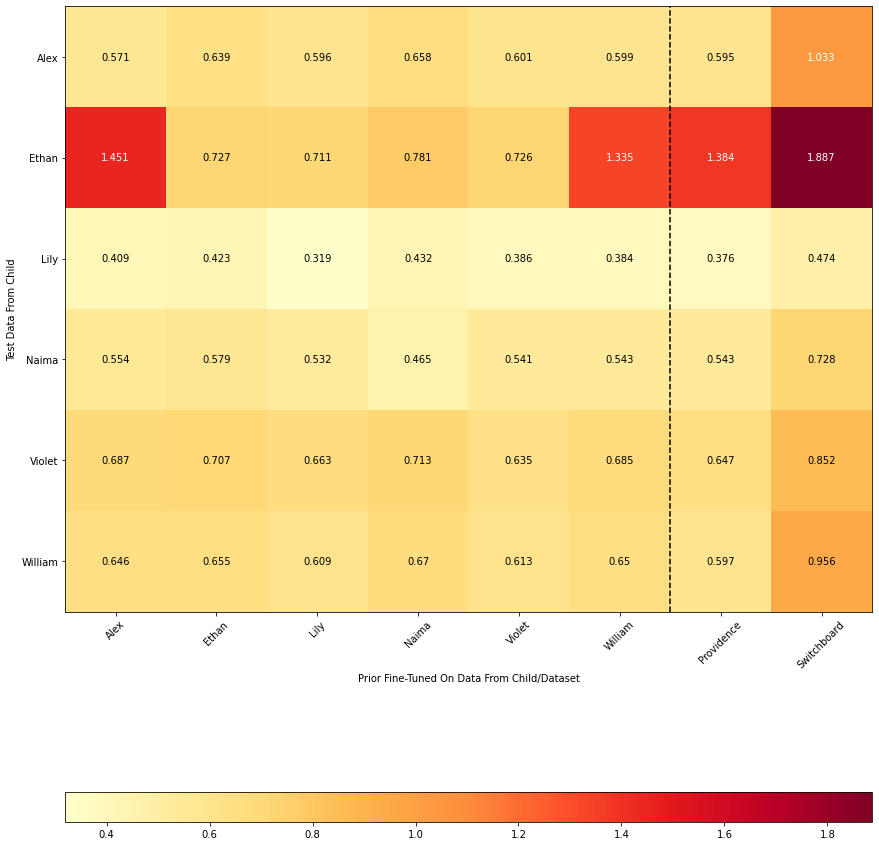

time: 1.17 s (started: 2022-05-25 10:27:23 -07:00)


In [9]:
posterior_score, posterior_limits = child_analysis.get_score_heatmap(childen_by_age, child_posteriors, 'posterior_probability','Posterior Probability', 1, '../../output/figures/child_cross_wfst_posterior.pdf', cmap="YlOrRd")

/home/stephan/notebooks/child-directed-listening/src/tier_3/../../src/analysis/child_analysis.py:194: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  


<Figure size 432x288 with 0 Axes>

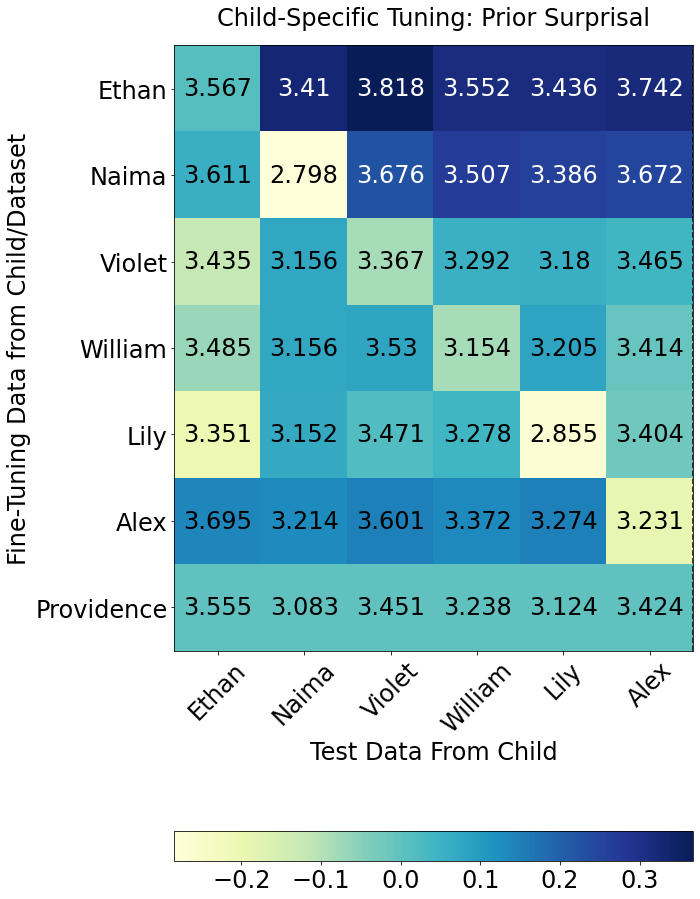

time: 827 ms (started: 2022-05-27 10:57:11 -07:00)


In [197]:
prior_fig, prior_limits = child_analysis.get_score_heatmap(
    childen_by_age,
    child_priors,
    'prior_probability',
    'Child-Specific Tuning: Prior Surprisal',
    .2, 
    '../../output/figures/child_cross_wfst_prior.pdf',
    normalize_by_child=True)

# Child-fitted WFST posteriors

In [131]:
child_specific_wfst_scores = child_analysis.assemble_child_scores_no_order('wfst-child')

Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence-Child_Alex_with_tagsxBERT_Providence-Child_Alex_20/wfst-child_run_models_across_time_*.pkl
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence-Child_Alex_with_tagsxBERT_Providence-Child_Ethan_20/wfst-child_run_models_across_time_*.pkl
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence-Child_Alex_with_tagsxBERT_Providence-Child_Lily_20/wfst-child_run_models_across_time_*.pkl
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence-Child_Alex_with_tagsxBERT_Providence-Child_Naima_20/wfst-child_run_models_across_time_*.pkl
Searching /home/stephan/notebooks/child-directed-listening/output/experiments/full_scale/eval/n=5000/Providence-Child_Alex_with_tagsxBERT_Providence-Child_Violet_20/wfst-child_run_models

In [132]:
child_specific_wfst_posterior_probabilities = [child_analysis.process_model_score(x, 'posterior_probability', 'mean')
        for x in child_specific_wfst_scores]

time: 935 ms (started: 2022-05-27 10:01:01 -07:00)


In [133]:
child_specific_wfst_posteriors = pd.concat(child_specific_wfst_posterior_probabilities)
child_specific_wfst_posteriors.sort_values(by=['test_dataset', 'training_dataset'])

,posterior_probability,training_split,training_dataset,test_split,test_dataset,n_samples
0,0.558151,Providence-Child,Alex,Providence-Child,Alex,9202
0,0.801248,Providence-Child,Ethan,Providence-Child,Alex,5560
0,0.796781,Providence-Child,Lily,Providence-Child,Alex,5560
0,0.881364,Providence-Child,Naima,Providence-Child,Alex,5560
0,0.750499,Providence-Child,Violet,Providence-Child,Alex,5560
0,0.730236,Providence-Child,William,Providence-Child,Alex,5560
0,1.036079,Switchboard,all,Providence-Child,Alex,5560
0,0.734979,Providence,all,Providence-Child,Alex,5560
0,1.472310,Providence-Child,Alex,Providence-Child,Ethan,3734
0,0.716775,Providence-Child,Ethan,Providence-Child,Ethan,15892


time: 44.8 ms (started: 2022-05-27 10:01:06 -07:00)


In [134]:
child_posteriors.loc[child_posteriors.test_dataset == child_posteriors.training_dataset]

,posterior_probability,training_split,training_dataset,test_split,test_dataset,n_samples,training_dataset_label
0,0.570774,Providence-Child,Alex,Providence-Child,Alex,9202,Alex
0,0.727055,Providence-Child,Ethan,Providence-Child,Ethan,15892,Ethan
0,0.319305,Providence-Child,Lily,Providence-Child,Lily,13281,Lily
0,0.464537,Providence-Child,Naima,Providence-Child,Naima,11976,Naima
0,0.634969,Providence-Child,Violet,Providence-Child,Violet,5938,Violet
0,0.649555,Providence-Child,William,Providence-Child,William,6577,William


time: 19.7 ms (started: 2022-05-27 10:01:11 -07:00)


In [135]:
%R -i child_specific_wfst_posteriors
%R -i child_posteriors

time: 53.7 ms (started: 2022-05-27 10:01:14 -07:00)


In [136]:
%%R
names(child_posteriors)[1] = 'posterior_probability_all_children'
child_posteriors$n_samples = NULL
names(child_specific_wfst_posteriors)[1] = 'posterior_probability_specific_children'
child_specific_wfst_posteriors$n_samples = NULL
cp = merge(child_posteriors, child_specific_wfst_posteriors)

time: 13.5 ms (started: 2022-05-27 10:01:16 -07:00)


In [137]:
%%R
wilcox.test(cp$posterior_probability_all_children, cp$posterior_probability_specific_children, paired=TRUE)


	Wilcoxon signed rank exact test

data:  cp$posterior_probability_all_children and cp$posterior_probability_specific_children
V = 75, p-value = 3.528e-09
alternative hypothesis: true location shift is not equal to 0

time: 42.3 ms (started: 2022-05-27 10:01:18 -07:00)


In [138]:
%%R
t.test(cp$posterior_probability_all_children, cp$posterior_probability_specific_children, paired=TRUE)


	Paired t-test

data:  cp$posterior_probability_all_children and cp$posterior_probability_specific_children
t = -4.0219, df = 47, p-value = 0.000208
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.15250994 -0.05080926
sample estimates:
mean of the differences 
             -0.1016596 

time: 56.8 ms (started: 2022-05-27 10:01:24 -07:00)


In [18]:
# plot the child posteriors, as possible figure C

time: 646 µs (started: 2022-05-25 10:27:37 -07:00)


In [194]:
import imp
imp.reload(child_analysis)

<module 'src.analysis.child_analysis' from '/home/stephan/notebooks/child-directed-listening/src/tier_3/../../src/analysis/child_analysis.py'>

time: 9.19 ms (started: 2022-05-27 10:31:59 -07:00)


In [154]:
childen_by_age

['Ethan', 'Naima', 'Violet', 'William', 'Lily', 'Alex']

time: 3.79 ms (started: 2022-05-27 10:12:21 -07:00)


/home/stephan/notebooks/child-directed-listening/src/tier_3/../../src/analysis/child_analysis.py:194: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  


<Figure size 432x288 with 0 Axes>

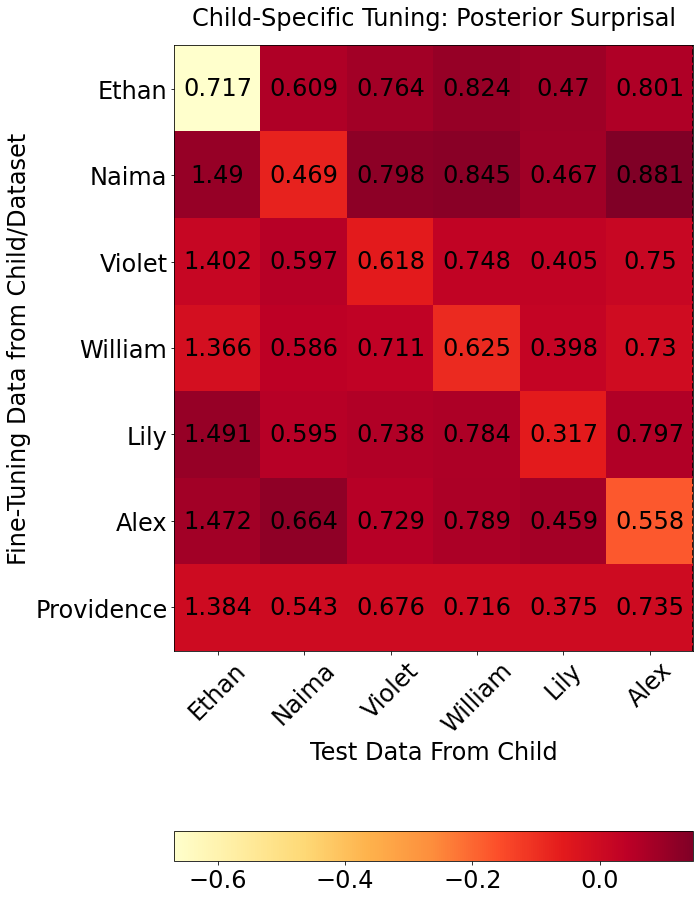

time: 767 ms (started: 2022-05-27 10:57:19 -07:00)


In [198]:
posterior_fig, posterior_limits = child_analysis.get_score_heatmap(childen_by_age, df=child_specific_wfst_posteriors,
    key='posterior_probability',title='Child-Specific Tuning: Posterior Surprisal',threshold=4, filename='../../output/figures/child_specific_wfst_posterior.pdf', 
    cmap="YlOrRd",exclude_adult_datasets= False, normalize_by_child=True)

In [ ]:
# def get_score_heatmap(df, key, title, threshold, filename,
#cmap="YlGnBu", exclude_adult_datasets=False, _min=None, _max=None, secondary_df=None, normalize_by_child=False):

In [21]:
# [X] remove the two additional datasets
# [X] empty values for the rest
# [X] copy the color limits of the previous plot

time: 1.1 ms (started: 2022-05-25 10:27:38 -07:00)


In [184]:
import imp
imp.reload(child_analysis)

<module 'src.analysis.child_analysis' from '/home/stephan/notebooks/child-directed-listening/src/tier_3/../../src/analysis/child_analysis.py'>

time: 15.2 ms (started: 2022-05-27 10:29:15 -07:00)


In [182]:
childen_by_age

['Ethan', 'Naima', 'Violet', 'William', 'Lily', 'Alex']

time: 3.48 ms (started: 2022-05-27 10:28:39 -07:00)


/home/stephan/notebooks/child-directed-listening/src/tier_3/../../src/analysis/child_analysis.py:194: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  


<Figure size 432x288 with 0 Axes>

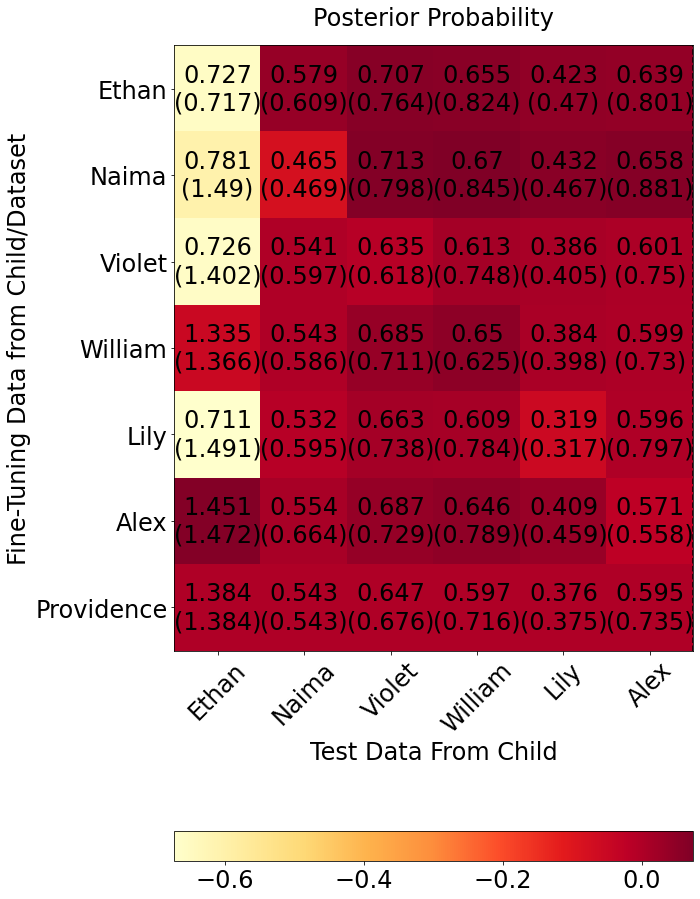

time: 1.06 s (started: 2022-05-27 10:29:17 -07:00)


In [185]:
posterior_score, posterior_limits = child_analysis.get_score_heatmap(
    childen_by_age,
    child_posteriors, 
    'posterior_probability',
    'Posterior Probability', 
    1, '../../output/figures/child_cross_wfst_posterior.pdf', 
    cmap="YlOrRd",
    secondary_df = child_specific_wfst_posteriors,
    normalize_by_child = True)

/home/stephan/notebooks/child-directed-listening/src/tier_3/../../src/analysis/child_analysis.py:194: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  


<Figure size 432x288 with 0 Axes>

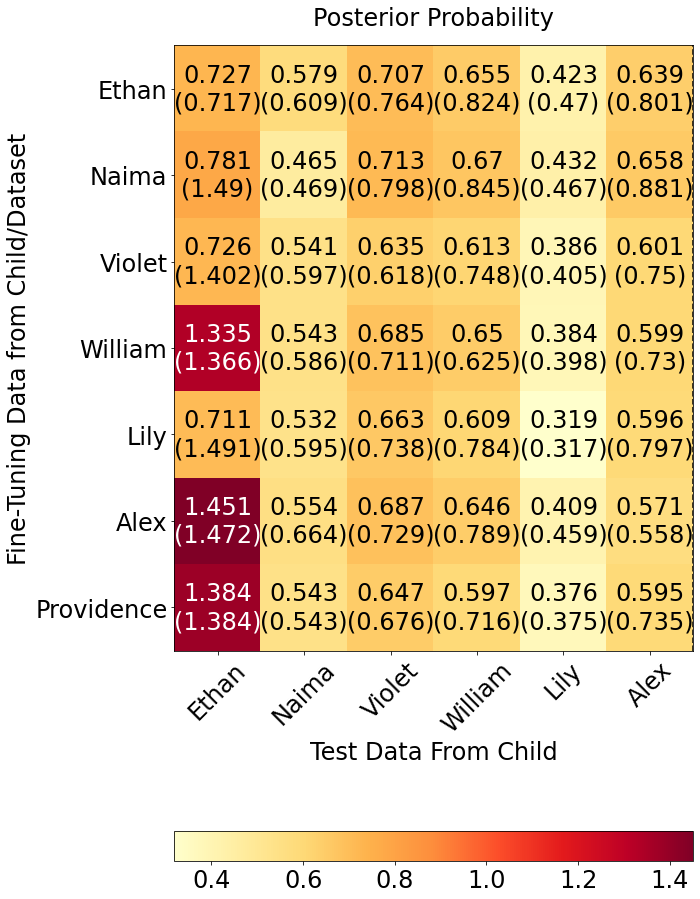

time: 896 ms (started: 2022-05-27 10:29:37 -07:00)


In [186]:
posterior_score, posterior_limits = child_analysis.get_score_heatmap(
    childen_by_age,
    child_posteriors, 
    'posterior_probability',
    'Posterior Probability', 
    1, '../../output/figures/child_cross_wfst_posterior.pdf', 
    cmap="YlOrRd",
    secondary_df = child_specific_wfst_posteriors,
    normalize_by_child = False)

In [24]:
import matplotlib
print(matplotlib.matplotlib_fname())


/home/stephan/notebooks/child-directed-listening/child-directed-listening-env/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc
time: 1.03 ms (started: 2022-05-25 10:27:39 -07:00)


# Statistical Tests for Observed Ranks

In [201]:
%%R
rank_tester = function(observed_ranks, num_samples){
	null_dist = sapply(1:num_samples, function(y){
		sum(sapply(c(1:6), function(x){sample(c(1:6), 1)}))		
	})

	null_df = data.frame(null_dist)
	names(null_df) = 'null_val'

	#ggplot(null_df) + geom_density(aes(x=null_val))+ geom_vline(xintercept=sum(observed_ranks), col='red')

	return(sum(null_df$null_val <= sum(observed_ranks)) / num_samples)
}

time: 14.8 ms (started: 2022-05-29 07:35:47 -07:00)


In [203]:
%%R
# prior
rank_tester(c(1,1,1,1,1,4), 10000)

[1] 0.0024
time: 770 ms (started: 2022-05-29 07:36:10 -07:00)


In [205]:
%%R
rank_tester(c(1,1,1,1,1,1), 10000)

[1] 0
time: 782 ms (started: 2022-05-29 07:36:22 -07:00)
